In [1]:
import pandas as pd
import numpy as np
import ijson
from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import ast
import itertools

converting the Json file to CSV and then dataframe keeping only the most important information for memory issues.\
font: https://www.kaggle.com/code/devintheai/citation-network-eda
We adapted the code found in this link to extract all the information, including the autors' information.

In [ ]:
"""
PAPERS = []

with open("D:\Primo Semestre\ADM\HW5\datasetHW5.json", "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]
        
        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan
        
        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0
        
        doc_type= element.get('doc_type') 
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan      

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string  
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan 
            paper['references']= np.nan
        
        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan               
        
        
        PAPERS.append(paper)

"""

Now we'll convert the information extracted in a dataframe and save them in a csv file, called "citations_network.csv"

In [5]:
"""
data = pd.DataFrame(PAPERS)
data.head()
data.to_csv("citations_network.csv", index=False)
"""

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,1091,Preliminary Design of a Network Protocol Learn...,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,Conference,2.0,2005687710;2018037215,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,Journal,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,Conference,15.0,1535888970;1992876689;1993710814;2035653341;20...,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...",4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,Conference,3.0,1560724230;1986968751;2156909104,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,Conference,NaN,NaN,NaN


our new dataset to create our subgraph for our investigation. Considering only the most connected componet of the graph.

In [2]:
df = pd.read_csv('citation_network.csv')

In [46]:
df.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,1091,Preliminary Design of a Network Protocol Learn...,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,Conference,2.0,2005687710;2018037215,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,Journal,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,Conference,15.0,1535888970;1992876689;1993710814;2035653341;20...,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...",4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,Conference,3.0,1560724230;1986968751;2156909104,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,Conference,NaN,NaN,NaN


## Data pre-processing
1. identify the top **10,000** papers with the highes number of citations
   
We just sorted the entire dataset in descending order according to the number of citation of each paper, and kept the first 10,000 rows.


In [3]:
df_s = df.sort_values(by='n_citation' ,ascending=False) 
df_s = df_s.head(10000).reset_index(drop=True)

In [4]:
# converting the authors' information from string to list
df_s['authors'] = df_s['authors'].apply(lambda row: ast.literal_eval(row))

In [79]:
df_s.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,2041404167,The Mathematical Theory of Communication,1.0,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327,Book,NaN,NaN,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...",1.0,"[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175,Book,NaN,NaN,NaN
2,2912565176,Fuzzy sets,1.0,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324


### Citation graph
- Representation of the paper's *citation relationships*, where each node is a paper and the edge between two nodes is present only if the starting node cites the second node.
- Unweighted
- Directed

2. The **nodes** of the graph

In [36]:
# the nodes of the graph will be all the unique rows that are present in the dataset

# creating the directed graph
cit_G = nx.DiGraph(name = 'Citation Graph')

# adding the nodes and the attributes (the columns of the dataset)
for i, pap in df_s.iterrows():
    node = pap['id']
    attributes = {}
    for el in list(df_s.columns)[1:]:
        attributes[el] = pap[el]
    cit_G.add_node(node, **attributes)

print(f'number of nodes in the Citation Graph: {len(cit_G.nodes())}')

number of nodes in the Citation Graph: 10000


3. The **edges** of the graph

The edges are defined by simply connecting each edge with all the paper's ids that specific paper cites; those can be found in the feature *references*.\
Those ids have been stored in a string separated by the ";", so what we'll do is to create a dictionary that is structured in the following way:
```python
{node_A : [node_B, node_c...], node_B : [node_i, ... ]}
```
where the key is the starting node and its value is a list of all the reachable nodes from it.

In [37]:
# the edges are all the papers' ids in the 'references' column
def citation_dict(row, d={}):
    if pd.notnull(row['references']):
        d[row['id']] = [int(cit) for cit in row['references'].split(';')]
    return d

# apply the function to each row in the DataFrame to save the citation's relationship in a dictionary
result_dict = {}
for idx, row in df_s.iterrows():
    result_dict = citation_dict(row, result_dict)

Now we'll use the dictionary ```result_dict``` to create the directed edges in the graph

In [38]:
for start in result_dict.keys():
    for end in result_dict[start]:
        cit_G.add_edge(start, end)

If we're interested in a rapresentatin of a portion of the graph (a subgraph of about 20 nodes, for the sake of a clearer view)

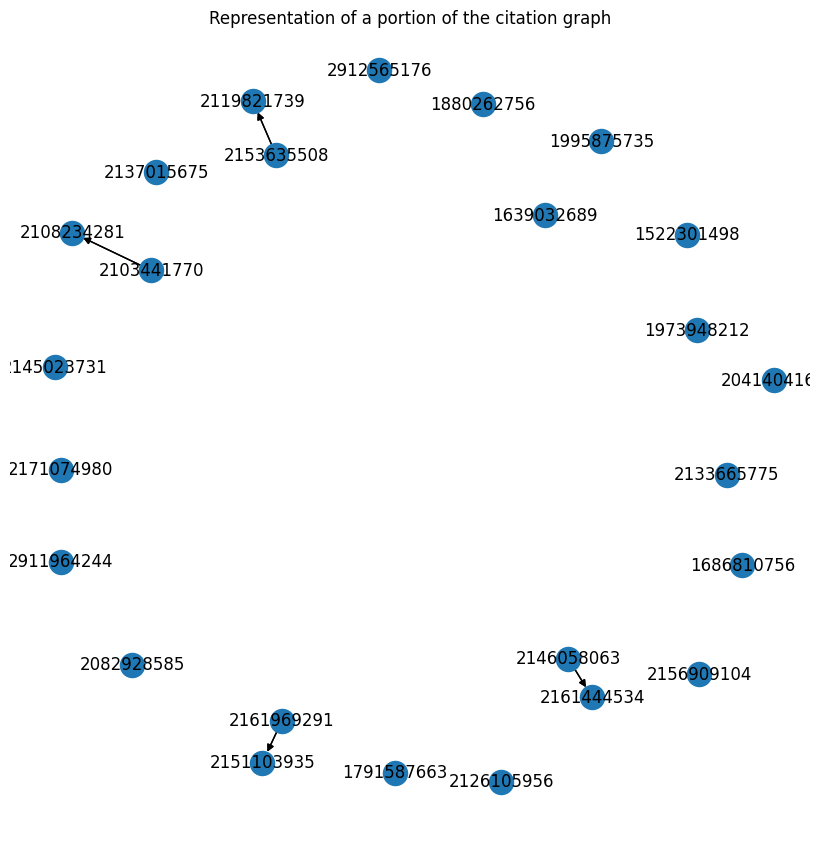

In [63]:
# creating a subgraph of ten nodes
subgraph = cit_G.subgraph(list(cit_G.nodes())[:25])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(8,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

### Collaboration graph
- Represents the *collaborations of the paper's authors*, where each node is an author and the undirected edge between two nodes represents the fact that those two authors have collaborated in a research paper. 
- Weighted: the weight will be the the number of research papers the couple of authors have worked on together.
- Undirected

2. The **nodes** of the graph
3. The **edges** of the graph: undirected and weighted

In [ ]:
collab_G = nx.Graph(name = 'Collaboration Graph') 

In [48]:
tqdm.pandas()

# dictionary to count the collaborations between each author's couple 
author_collaborations = {}
for authors_list in df_s['authors']:
    author_ids = [author['id'] for author in authors_list]  # extract the author's id for each paper
    author_combinations = itertools.combinations(author_ids, 2) # find all the possible combinations of the authors for the current paper
    
    for pair in author_combinations: # keep the count of the collaborations for each author's couple
        pair = tuple(sorted(pair))  # sort the ids to keep coherence in the couple
        if pair not in author_collaborations.keys():
            author_collaborations[pair] = 1
        else:
            author_collaborations[pair] += 1

# now create the graph with the author's couple of edges, networkX will automatically create the nodes if not present already

for authors, num_collab in author_collaborations.items():
    author1, author2 = authors
    collab_G.add_edge(author1, author2, weight=num_collab) # create the graph with the weighted edges: the number of times each author worked with the other

# now we have to add all the authors that have never collaborated with anyone else  
def apply_record(G, data):
  authors_list = []
  for author in data['authors']:
    authors_list.append(author['id'])
    G.add_node(author['id'], name=author['name'])
    if 'org' in author:
      G.nodes()[author['id']]['org'] = author['org']

df_s.progress_apply(lambda row: apply_record(collab_G, row), axis=1)

print(f'number of nodes in the Collaboration Graph: {len(collab_G.nodes())}')
print(f'number of edges in the Collaboration Graph: {len(collab_G.edges())}')

  0%|          | 0/10000 [00:00<?, ?it/s]

number of nodes in the Collaboration Graph: 21235
number of edges in the Collaboration Graph: 136478


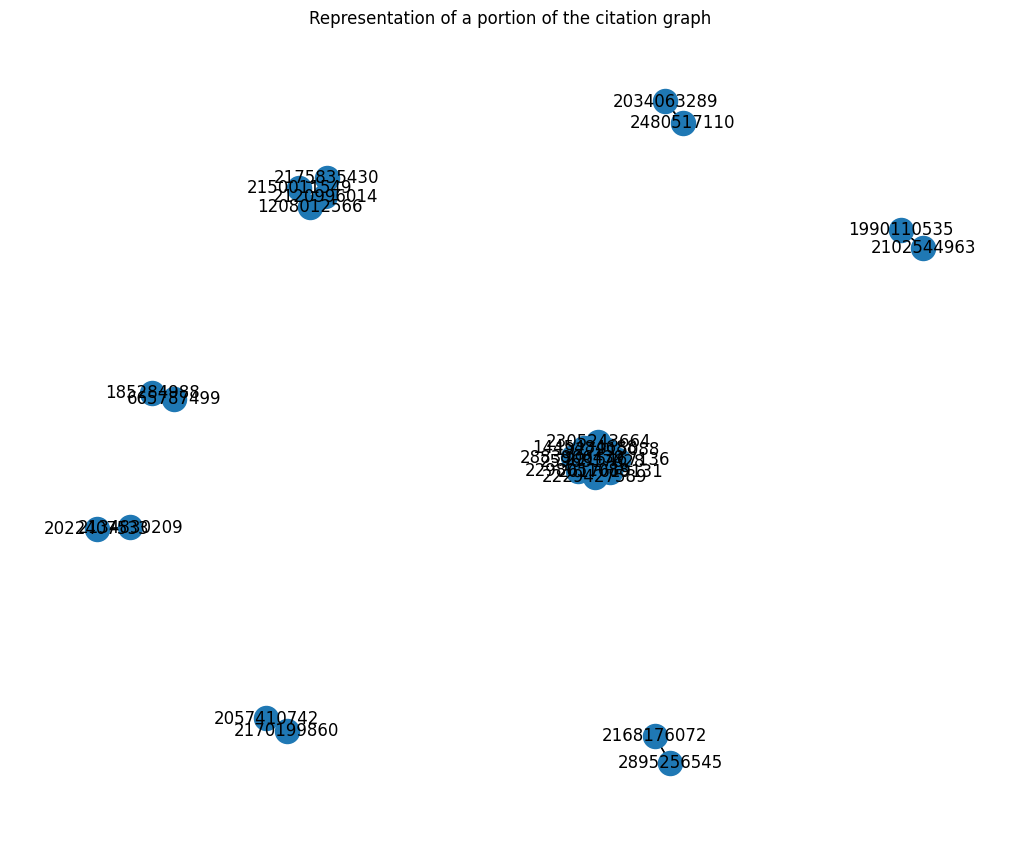

In [35]:
# creating a subgraph of ten nodes
subgraph = collab_G.subgraph(list(collab_G.nodes())[:25])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(10,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

As a final step, we can save the graphs in a GraphML file

In [47]:
nx.write_graphml(collab_G, "Collaboration_Graph.graphml")

# in order to save the citation graph, we have to remove the author attribute, because is a list and is not supported by GraphML
for node in cit_G.nodes():
    if 'authors' in cit_G.nodes[node]:
        del cit_G.nodes[node]['authors']
nx.write_graphml(cit_G, "Citation_Graph.graphml")